In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jupyter_core import paths
paths.jupyter_config_path()

['/Users/arnull/.jupyter',
 '/Users/arnull/.local/etc/jupyter',
 '/Users/arnull/miniconda3/envs/torch2/etc/jupyter',
 '/usr/local/etc/jupyter',
 '/etc/jupyter']

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scistats
import torch
import torch.distributions

from blackbirds.infer import mcmc

## Conjugate Normal

In [2]:
mu_0, sigma_0 = 1., 2.
prior = torch.distributions.normal.Normal(mu_0, sigma_0)

In [3]:
sigma = 1.

def negative_log_likelihood(theta, data):
    dist = torch.distributions.normal.Normal(theta, sigma)
    return - dist.log_prob(data).sum()

In [4]:
data_size = 3
data = torch.distributions.normal.Normal(-1., sigma).sample((data_size,))

In [5]:
data

tensor([-1.8336,  0.2126, -0.1315])

### Sampling

In [6]:
mala = mcmc.MALA(prior, negative_log_likelihood, w=1.)

In [7]:
sampler = mcmc.MCMC(mala, 10_000)

In [10]:
trial_samples = sampler.run(torch.tensor([-.5]), data)

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9332/10000 [00:10<00:00, 878.93it/s, Acceptance rate=0.288]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
thinned_trial_samples = torch.stack(trial_samples)[::100].T
scale = torch.cov(thinned_trial_samples)

In [12]:
mala = mcmc.MALA(prior, negative_log_likelihood, 1.)
sampler = mcmc.MCMC(mala, 20_000)
post_samples = sampler.run(torch.tensor([thinned_trial_samples.mean()]), data, scale=scale)

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 15801/20000 [00:17<00:04, 896.85it/s, Acceptance rate=0.824]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 18900/20000 [00:21<00:01, 910.89it/s, Acceptance rate=0.823]IOPub data rate exceeded.
The Jupyter server wi

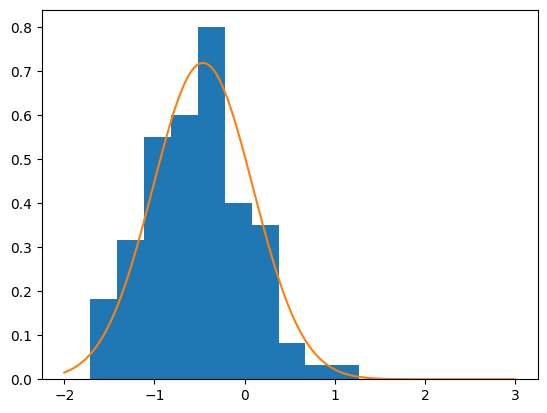

In [13]:
plt.hist(torch.stack(post_samples).T.numpy()[0, ::100], density=True)
x = np.linspace(-2, 3., 1000)
plt.plot(x, scistats.norm.pdf(x, 
                              (mu_0/sigma_0**2 + data.sum()/sigma**2)/(1/sigma_0**2 + data_size/sigma**2),
                              1/np.sqrt((1/sigma_0**2 + data_size/sigma**2))))

## Conjugate multivariate Normal 

In [14]:
mu_0, sigma_0 = torch.tensor([2., 0.]), torch.tensor([[2., 0.,], [0., 1.]])
prior = torch.distributions.multivariate_normal.MultivariateNormal(mu_0, sigma_0)

(-2.0, 6.0)

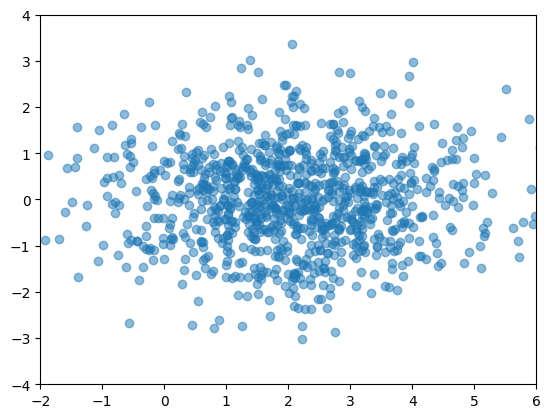

In [15]:
prior_samples = prior.sample((1000,))
plt.scatter(prior_samples[:,0], prior_samples[:, 1], alpha=0.5)
plt.ylim([-4,4])
plt.xlim([-2,6])

In [16]:
sigma = torch.tensor([[1., 0.4,], [0.4, 2.]])

def negative_log_likelihood(data, theta):
    dist = torch.distributions.multivariate_normal.MultivariateNormal(theta, sigma)
    return - dist.log_prob(data).sum()

In [17]:
data_size = 3
true_mean = torch.tensor([-1., 2.])
true_density = torch.distributions.multivariate_normal.MultivariateNormal(true_mean, sigma)
data = true_density.sample((data_size,))

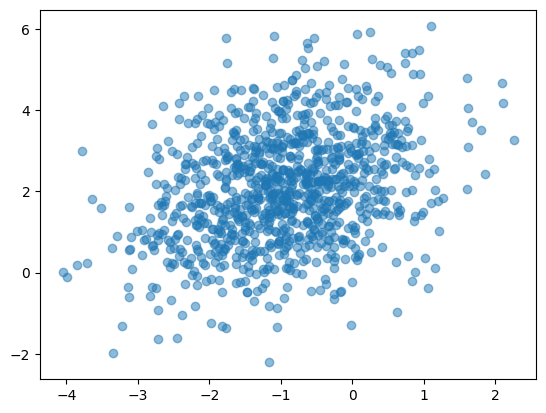

In [18]:
true_density_samples = true_density.sample((1000,))
plt.scatter(true_density_samples[:,0], true_density_samples[:,1], alpha=0.5)

In [19]:
data

tensor([[-1.7573,  0.1746],
        [-1.2320,  4.3385],
        [-2.6572,  0.2604]])

### Sampling

In [20]:
mala = mcmc.MALA(prior, negative_log_likelihood, w=1.)

In [21]:
sampler = mcmc.MCMC(mala, 20_000)

In [22]:
trial_samples = sampler.run(torch.tensor([-2., -.5]), data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 746.55it/s, Acceptance rate=0.11]


In [23]:
thinned_trial_samples = torch.stack(trial_samples)[::100].T
cov = torch.cov(thinned_trial_samples)

In [24]:
init_state = thinned_trial_samples.mean(dim=1)

In [25]:
mala = mcmc.MALA(prior, negative_log_likelihood, 1.)
sampler = mcmc.MCMC(mala, 20_000)
post_samples = sampler.run(init_state, data, covariance=cov)

  0%|                                                                                                                                                                                                                                                                                             | 0/20000 [00:00<?, ?it/s]


RuntimeError: grad can be implicitly created only for scalar outputs

In [26]:
inv_sigma_0 = torch.inverse(sigma_0)
inv_sigma = torch.inverse(sigma)
inv_additions = torch.inverse(inv_sigma_0 + data_size*inv_sigma)
true_mean = torch.matmul(inv_additions, 
                         (torch.matmul(inv_sigma_0, mu_0) + data_size*torch.matmul(inv_sigma, data.mean(dim=0))))
true_cov = torch.inverse(inv_sigma_0 + data_size*inv_sigma)
true_post = torch.distributions.multivariate_normal.MultivariateNormal(true_mean, true_cov)
true_post_samples = true_post.sample((1000,))

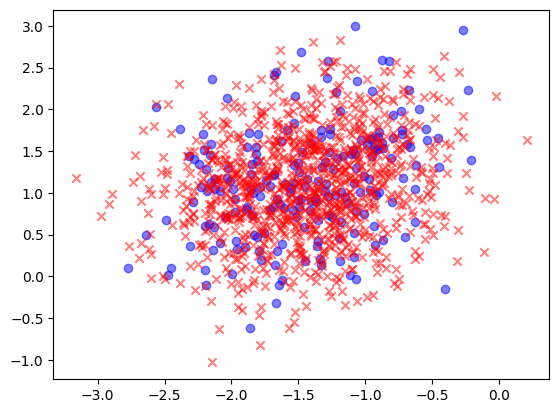

In [27]:
post_samples_numpy = torch.stack(post_samples).T.numpy()
plt.scatter(post_samples_numpy[0, ::100], post_samples_numpy[1, ::100], alpha=0.5, c='b')
plt.scatter(true_post_samples[:, 0], true_post_samples[:, 1], alpha=0.5, c='r', marker='x')